<a href="https://colab.research.google.com/github/hs1955/INT2_NN/blob/main/Group7F102ClassifierFINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Very Helpful link
# https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [30]:
# Install torchviz on Google Colab
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
# Makes File Handling Easier
from collections import OrderedDict
import math
import os
import shutil
import time
import gc

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

# Model Summary
from torchsummary import summary
from torchviz import make_dot

# Image datasets and image manipulation
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd

# Image display
import matplotlib.pyplot as plt
import numpy as np

# Unpacker for .mat files
import scipy.io as scio


In [32]:
# Free up any memory in the GPU
torch.cuda.empty_cache()


In [55]:
# Hyper Parameters
BATCH_SIZE = 16
NUM_OF_CLASSES = 102

# Optimizing
LEARN_RATE = 0.001
WEIGHT_DECAY = 0.0001

# Training
MAX_TRAIN_TIME = 60 * 60 * 4
NUM_EPOCHS = 100
CHANCES_TO_IMPROVE = 30

CHECKPOINT_PERIOD = 100

# Transforms
CROP_SIZE = 500
RESIZE_SIZE = 256


In [34]:
### OLD CODE FOR LOADING DATASET
# # Create train, valid and test directories to sort dataset into.
# def makePartitionDirs():
#     for i in range(1, 103):
#         os.makedirs("data/102flowers/train/" + str(i), exist_ok=True)
#         os.makedirs("data/102flowers/test/" + str(i), exist_ok=True)
#         os.makedirs("data/102flowers/valid/" + str(i), exist_ok=True)

# # # Now obsolete manual partioner for Flowers102 dataset.
# # Distribute dataset into train, valid and test directories according to setid.mat specifications.
# def partitionData(imageLabels, setid, sortedPath, dataPath):
#     for i in range(len(imageLabels["labels"][0])):
#         filename = "image_" + str(i + 1).zfill(5) + ".jpg"
#         if i + 1 in setid["trnid"][0]:
#             targetFolder = os.path.join(
#                 sortedPath, "train", str(imageLabels["labels"][0][i])
#             )
#         elif i + 1 in setid["valid"][0]:
#             targetFolder = os.path.join(
#                 sortedPath, "valid", str(imageLabels["labels"][0][i])
#             )
#         else:
#             targetFolder = os.path.join(
#                 sortedPath, "test", str(imageLabels["labels"][0][i])
#             )
#         shutil.copy(
#             os.path.join(dataPath, filename), os.path.join(targetFolder, filename)
#         )


In [35]:
# Commonly-used normalisation values across numerous NNs like Resnet18 and ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
trainTransforms = transforms.Compose(
    [
        transforms.CenterCrop((CROP_SIZE, CROP_SIZE)),
        transforms.Resize((RESIZE_SIZE, RESIZE_SIZE)),
        # transforms.RandomRotation([-90, 180]),
        transforms.RandomRotation(degrees=90),
        transforms.RandomAutocontrast(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)
testTransforms = validTransforms = transforms.Compose(
    [
        transforms.Resize((RESIZE_SIZE, RESIZE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)


In [36]:
dataPath = "data/flowers-102"
trainingData = torchvision.datasets.Flowers102("data", "train", trainTransforms, download=True)
validationData = torchvision.datasets.Flowers102("data", "val", validTransforms, download=True)
testingData = torchvision.datasets.Flowers102("data", "test", testTransforms, download=True)
setid = scio.loadmat(dataPath + f"/setid.mat")
imageLabels: dict = scio.loadmat(dataPath + f"/imagelabels.mat")

# Data loaders for use as input.
trainDataLoader = torch.utils.data.DataLoader(
    trainingData, batch_size=BATCH_SIZE, shuffle=True
)
validDataLoader = torch.utils.data.DataLoader(
    validationData, batch_size=BATCH_SIZE, shuffle=False
)
testDataLoader = torch.utils.data.DataLoader(
    testingData, batch_size=BATCH_SIZE, shuffle=False
)


In [37]:
def showImage(image):
    npImage = image.cpu().numpy() / 3.5 + 0.4 # Mostly undoes normalisation for display purposes
    plt.imshow(np.transpose(npImage, (1, 2, 0)))
    plt.show()


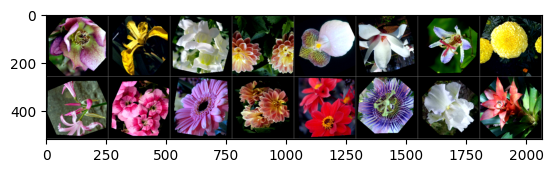

39 14 10 59 1 86 78 46 36 29 40 59 55 76 67 98


In [38]:
def printSampleImages(dataLoader, classIndexes):
    dataIter = iter(trainDataLoader)
    images, labels = next(dataIter)
    showImage(torchvision.utils.make_grid(images))
    print(" ".join(f"{labels[j]}" for j in range(BATCH_SIZE)))
printSampleImages(trainDataLoader, trainingData)


In [39]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.tensorMulti = 24 * 64**2

        # self.features = nn.Sequential(
        #     nn.Conv2d(3,32,kernel_size=3,padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2,2),

        #     nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2,2),

        #     # nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        #     # nn.ReLU(),
        #     # nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        #     # nn.ReLU(),
        #     # # nn.Dropout2d(p=0.5),
        #     # nn.MaxPool2d(2,2)
        # )

        # self.classifier = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(self.tensorMulti,1024),
        #     # nn.ReLU(),
        #     # nn.Linear(1024,512),
        #     nn.ReLU(),
        #     nn.Linear(1024,102)
        # )

        self.features = nn.Sequential(OrderedDict([
            ("conv1", nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1)),
            ("bn1", nn.BatchNorm2d(num_features=6)),
            ("relu1", nn.ReLU()),
            ("conv2", nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1)),
            ("bn2", nn.BatchNorm2d(num_features=12)),
            ("relu2", nn.ReLU()),
            ("pool", nn.MaxPool2d(2, 2)),
            ("conv4", nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)),
            ("bn4", nn.BatchNorm2d(num_features=24)),
            ("relu3", nn.ReLU()),
            ("conv5", nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)),
            ("bn5", nn.BatchNorm2d(num_features=24)),
            ("relu4", nn.ReLU()),
            ("pool2", nn.MaxPool2d(2, 2)),
            ("dp1", nn.Dropout2d(p = 0.4)),

            # # New layers underneath
            # ("pool2", nn.MaxPool2d(2, 2)),
            # ("conv6", nn.Conv2d(in_channels=24, out_channels=36, kernel_size=5, stride=1, padding=2)),
            # ("bn6", nn.BatchNorm2d(num_features=36)),
            # ("relu5", nn.ReLU()),
        ]))

        self.classifier = nn.Sequential(OrderedDict([
            # ("fc0", nn.Linear(in_features=self.tensorMulti, out_features=self.tensorMulti//NUM_OF_CLASSES)),
            # ("relu6", nn.ReLU()),
            # ("fc1", nn.Linear(in_features=self.tensorMulti//NUM_OF_CLASSES, out_features=NUM_OF_CLASSES)),
            ("fc1", nn.Linear(in_features=self.tensorMulti, out_features=NUM_OF_CLASSES)),
        ]))


    def forward(self, input_img):
        output = self.features(input_img)
        # output = input_img
        # for layer in self.features:
        #   output = layer(output)
        # print(output.shape)
        output = output.view(-1, self.tensorMulti)
        # print(output.shape)
        output = self.classifier(output)
        return output

# Define your execution device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

# Instantiate a neural network model
model = ConvNet()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARN_RATE, weight_decay=WEIGHT_DECAY)

model = model.to(device)

# Define the loss function with Classification Cross-Entropy loss and an optimizer with SGD optimizer
lossFunction  = nn.CrossEntropyLoss()


The model will be running on cuda device


In [40]:
# Function to save the model
def saveModel(path = "./firstF102Model.pth"):
    torch.save(model.state_dict(), path)


In [41]:
# Function to test the model with the validation dataset and print the accuracy for the validation images
def trainingAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in trainDataLoader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # run the model on the train set to predict labels
            outputs = model(images)
            # the label with the highest value will be predicted
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


In [42]:
def validateAccuracy(model):
    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in validDataLoader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest value will be predicted
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


In [43]:
def plotAccuracies(trainAccuracies, validAccuracies):
    epochs = len(trainAccuracies)
    fig, ax1 = plt.subplots()
    ax1.plot(range(epochs), trainAccuracies, label='Training accuracy')
    ax1.plot(range(epochs), validAccuracies, label='Validation accuracy')
    ax1.set_title('Training and Validation Accuracies per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()


In [44]:
# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(save_model_path, bestAccuracy = 0.0):
    startTime = time.time()
    lastCheckpointTime = startTime
    trainAccuracies = []
    validAccuracies = []
    # # Define your execution device
    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # print("The model will be running on", device, "device")
    # # Convert model parameters and buffers to CPU or Cuda
    # model.to(device) # Regretfully AMD GPUs are unsupported for PyTorch models.

    runningAccuracy = 0.0
    fails_to_imprv = 0

    for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
        # Evaluation and Training of the Dataset
        model.train()
        runningLoss = 0.0

        print("\n##############################")
        for i, (images, labels) in enumerate(trainDataLoader):
            # Get the inputs
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Predict classes using images from the training set
            outputs = model(images)
            # Compute the loss based on model output and real labels
            loss = lossFunction(outputs.to(device), labels)
            # Back-propagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()
            runningLoss += loss.item()  # extract the loss value
            if i % BATCH_SIZE == BATCH_SIZE - 1:
                # print twice per epoch
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, runningLoss / BATCH_SIZE))
                # zero the loss
                runningLoss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all validation images
        trainAccuracy = trainingAccuracy()
        trainAccuracies.append(trainAccuracy)
        validAccuracy = validateAccuracy(model)
        validAccuracies.append(validAccuracy)
        plotAccuracies(trainAccuracies, validAccuracies)
        print(
            "For epoch",
            epoch + 1,
            "the training accuracy over the whole training set is %.2f %%" % (trainAccuracy),
            "\nthe validation accuracy over the whole validation set is %.2f %%" % (validAccuracy),
        )
        elapsedTime = time.time() - lastCheckpointTime
        if elapsedTime >= CHECKPOINT_PERIOD and validAccuracy > bestAccuracy:
            saveModel(save_model_path)
            lastCheckpointTime = time.time()

        # Check if the maximum training time has elapsed
        elapsedTime  = time.time() - startTime
        if elapsedTime  >= MAX_TRAIN_TIME:
            if validAccuracy > bestAccuracy:
                saveModel(save_model_path)
            break

        if validAccuracy > runningAccuracy:
            print("Improvement made: %.2f%% better." % (validAccuracy - runningAccuracy))
            runningAccuracy = validAccuracy
            fails_to_imprv = 0
        else:
            fails_to_imprv += 1
            print("Failed to improve: %d, %.2f%% worse." % (fails_to_imprv, (runningAccuracy - validAccuracy)))
            if fails_to_imprv >= CHANCES_TO_IMPROVE:
              print("Failed to improve %d consecutive times." % fails_to_imprv)
              break

        # Check if the maximum training time has elapsed
        elapsedTime  = time.time() - startTime
        if (elapsedTime  >= MAX_TRAIN_TIME and validAccuracy > bestAccuracy) or (fails_to_imprv > CHANCES_TO_IMPROVE):
            saveModel(save_model_path)
            break

        # we want to save the model if the accuracy is the best
        if validAccuracy > bestAccuracy:
            saveModel(save_model_path)
            bestAccuracy = validAccuracy


In [45]:
# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader
    dataIter = iter(testDataLoader)
    images, labels = next(dataIter)
    images, labels = images.to(device), labels.to(device)
    showImage(torchvision.utils.make_grid(images))
    print(
        "Real classes: ",
        " ".join(f"{labels[j]}" for j in range(BATCH_SIZE)),
    )
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)

    # get probabilities for all 102 labels. The highest (max) probability should align with correct label
    _, predicted = torch.max(outputs, 1)

    # show the predicted labels on the screen with the real ones for comparison
    print(
        "Predicted: ",
        " ".join(f"{predicted[j]}" for j in range(BATCH_SIZE)),
    )


In [46]:
# Function to validate the model with a batch of images from the validation set.
def validBatch():
    model.eval()
    dataIter = iter(validDataLoader)
    images, labels = next(dataIter)
    images, labels = images.to(device), labels.to(device)
    showImage(torchvision.utils.make_grid(images))
    print(
        "Real classes: ",
        " ".join(f"{labels[j]}" for j in range(BATCH_SIZE)),
    )
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    print(
        "Predicted: ",
        " ".join(f"{predicted[j]}" for j in range(BATCH_SIZE)),
    )


In [47]:
def trainOurModel(save_model_path = "firstF102Model.pth"):
    # Used to ensure the best AI is not overwritten
    best_accuracy = 0.0
    
    # if os.path.isfile(save_model_path):
    #     best_model = ConvNet()
    #     # best_optimizer = torch.optim.SGD(best_model.parameters(), lr=LEARN_RATE, weight_decay=WEIGHT_DECAY)
    #     best_model.load_state_dict(torch.load(save_model_path))
    #     best_accuracy = validateAccuracy(best_model)

    # print(f"Best Accuracy: {best_accuracy}")

    # Let's build our model
    train(save_model_path, best_accuracy)
    print("Finished Training")

    # Test which classes performed well
    validateAccuracy(model)

    # Let's load the model we just created and test the accuracy per label
    # Optimizer
    model.load_state_dict(torch.load(save_model_path))

    # Test with  of images
    validBatch()

    # Test on the whole dataset
    testClasses()


In [68]:
# Function to test what classes performed well
# def testClasses():
#     model.eval()
#     class_correct = list(0.0 for i in range(NUM_OF_CLASSES))
#     class_total = list(0.0 for i in range(NUM_OF_CLASSES))
#     with torch.no_grad():
#         dataIter = iter(testDataLoader)
#         images, labels = next(dataIter)
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)
#         c = (predicted == labels).squeeze()
#         for i in range(BATCH_SIZE):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1


#     for i in range(NUM_OF_CLASSES):
#         print(
#             "Accuracy of %5s : %2d %%"
#             % (i, 100 * class_correct[i] / class_total[i])
#         )
def testClasses(device):
    model.eval()
    testLoss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testDataLoader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = lossFunction(outputs, labels)
            testLoss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute the average test loss and accuracy
    testLoss /= len(testDataLoader)
    accuracy = correct / total

    # Print the results
    print(f"Test Loss: {testLoss:.4f}, Test Accuracy: {accuracy*100:.2f}%")

In [49]:
summary(model, (3, RESIZE_SIZE, RESIZE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 256, 256]             168
       BatchNorm2d-2          [-1, 6, 256, 256]              12
              ReLU-3          [-1, 6, 256, 256]               0
            Conv2d-4         [-1, 12, 256, 256]             660
       BatchNorm2d-5         [-1, 12, 256, 256]              24
              ReLU-6         [-1, 12, 256, 256]               0
         MaxPool2d-7         [-1, 12, 128, 128]               0
            Conv2d-8         [-1, 24, 128, 128]           2,616
       BatchNorm2d-9         [-1, 24, 128, 128]              48
             ReLU-10         [-1, 24, 128, 128]               0
           Conv2d-11         [-1, 24, 128, 128]           5,208
      BatchNorm2d-12         [-1, 24, 128, 128]              48
             ReLU-13         [-1, 24, 128, 128]               0
        MaxPool2d-14           [-1, 24,

In [50]:
# Print graph of network
# batch = next(iter(trainDataLoader))

# tmp = torch.randn(BATCH_SIZE, 3, 256, 256)
# yhat = model(tmp) # Dummy batch
# make_dot(tmp, params=dict(model.named_parameters())).render("rnn_torchviz", format="png")


##############################
[1,    16] loss: 2.685
[1,    32] loss: 2.755
[1,    48] loss: 2.717
[1,    64] loss: 2.924
For epoch 1 the training accuracy over the whole training set is 50.39 % 
the validation accuracy over the whole validation set is 23.73 %
Improvement made: 23.73% better.

##############################
[2,    16] loss: 2.700
[2,    32] loss: 2.641
[2,    48] loss: 2.678
[2,    64] loss: 2.697
For epoch 2 the training accuracy over the whole training set is 45.88 % 
the validation accuracy over the whole validation set is 26.86 %
Improvement made: 3.14% better.

##############################
[3,    16] loss: 2.672
[3,    32] loss: 2.563
[3,    48] loss: 2.575
[3,    64] loss: 2.356
For epoch 3 the training accuracy over the whole training set is 47.94 % 
the validation accuracy over the whole validation set is 26.47 %
Failed to improve: 1, 0.39% worse.

##############################
[4,    16] loss: 2.630
[4,    32] loss: 2.689
[4,    48] loss: 2.568
[4,    64]

<ipython-input-43-55020dce03bb>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots()


For epoch 21 the training accuracy over the whole training set is 53.92 % 
the validation accuracy over the whole validation set is 27.84 %
Failed to improve: 3, 1.37% worse.

##############################
[22,    16] loss: 2.279
[22,    32] loss: 2.497
[22,    48] loss: 2.299
[22,    64] loss: 2.338
For epoch 22 the training accuracy over the whole training set is 55.59 % 
the validation accuracy over the whole validation set is 27.75 %
Failed to improve: 4, 1.47% worse.

##############################
[23,    16] loss: 2.282
[23,    32] loss: 2.217
[23,    48] loss: 2.340
[23,    64] loss: 2.305
For epoch 23 the training accuracy over the whole training set is 55.59 % 
the validation accuracy over the whole validation set is 28.63 %
Failed to improve: 5, 0.59% worse.

##############################
[24,    16] loss: 2.167
[24,    32] loss: 2.458
[24,    48] loss: 2.360
[24,    64] loss: 2.226
For epoch 24 the training accuracy over the whole training set is 53.43 % 
the validation a

KeyboardInterrupt: ignored

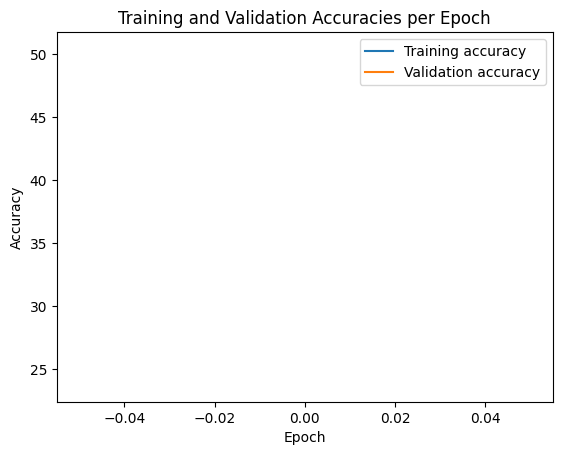

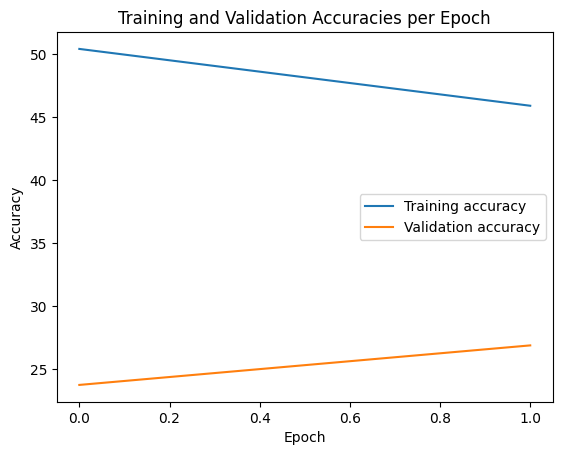

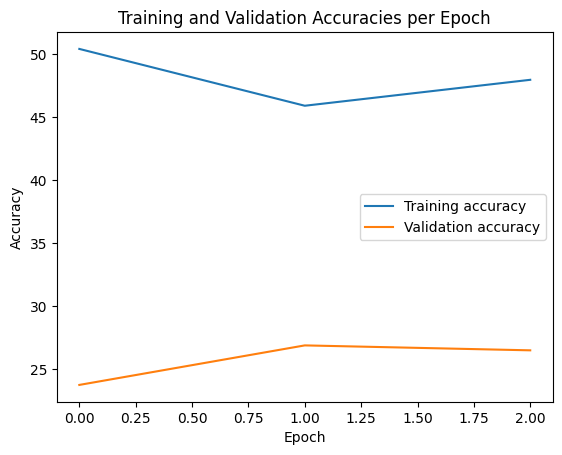

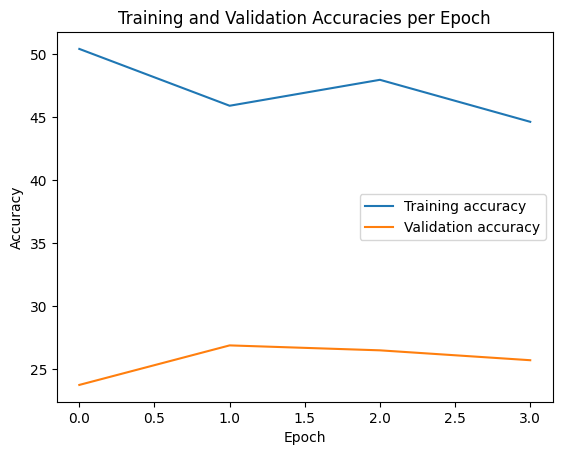

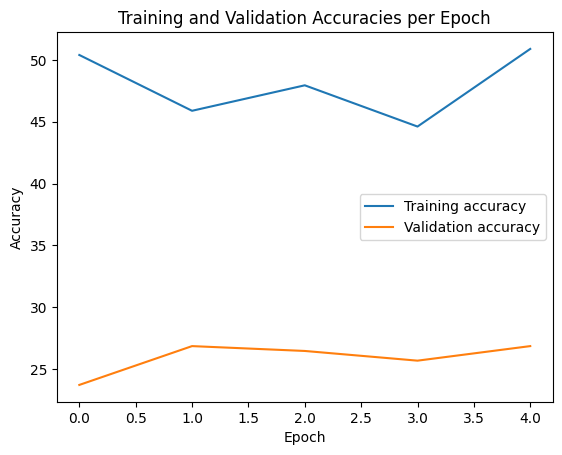

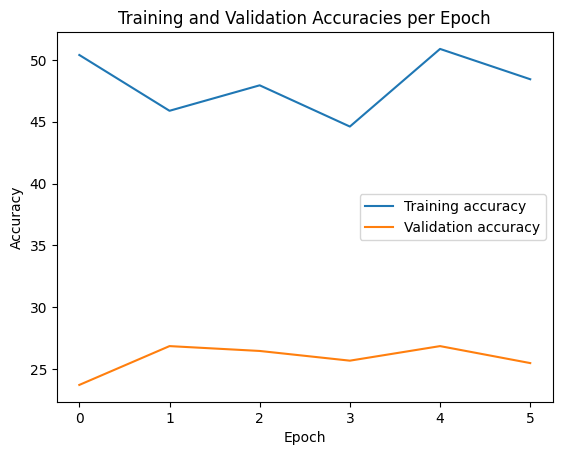

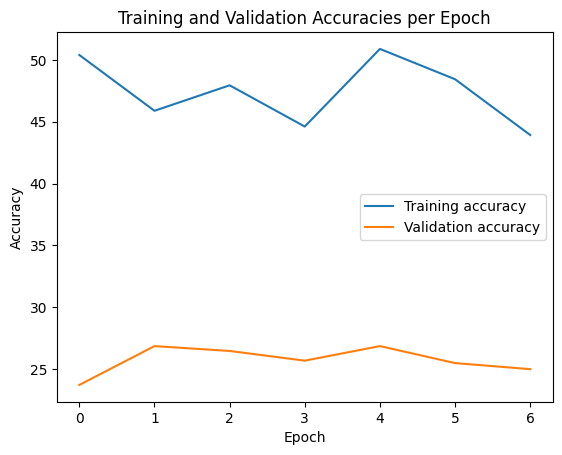

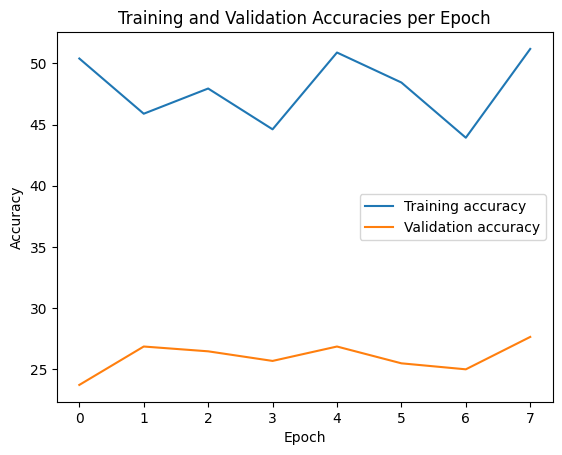

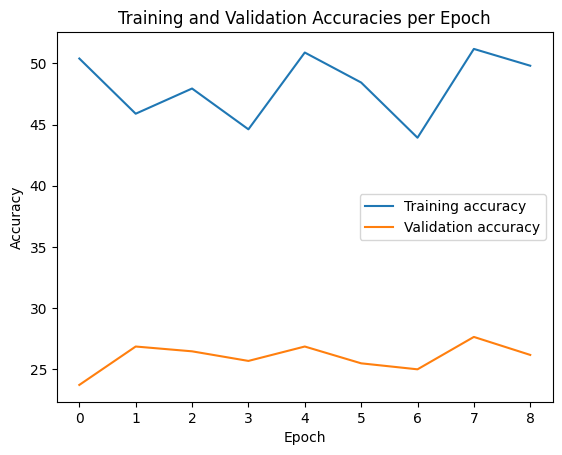

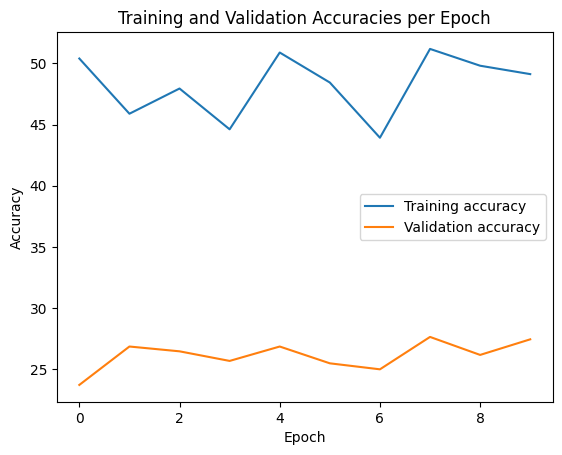

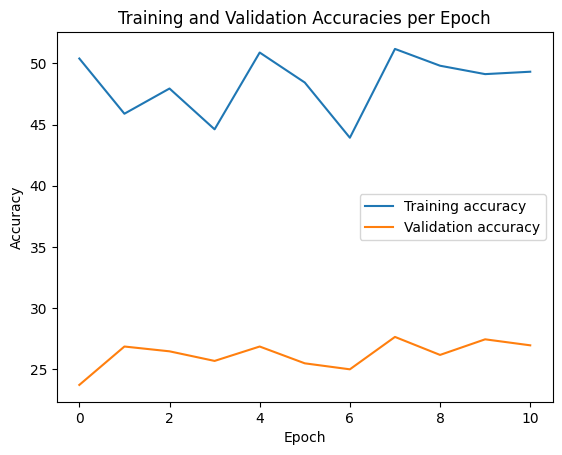

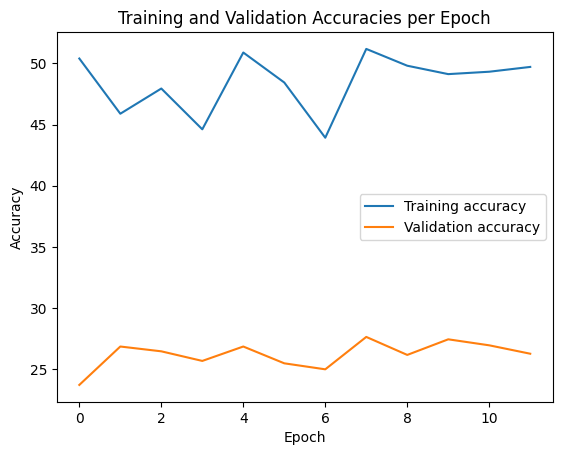

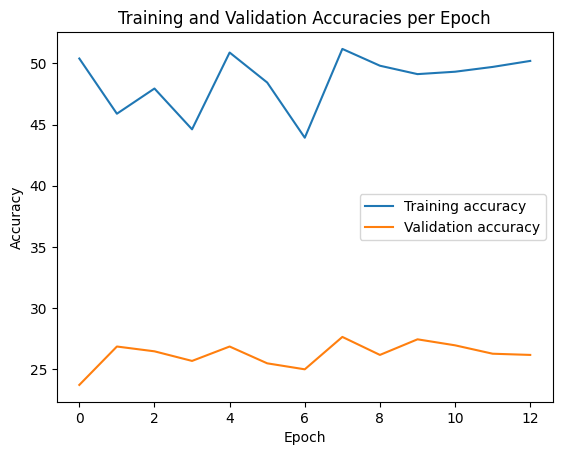

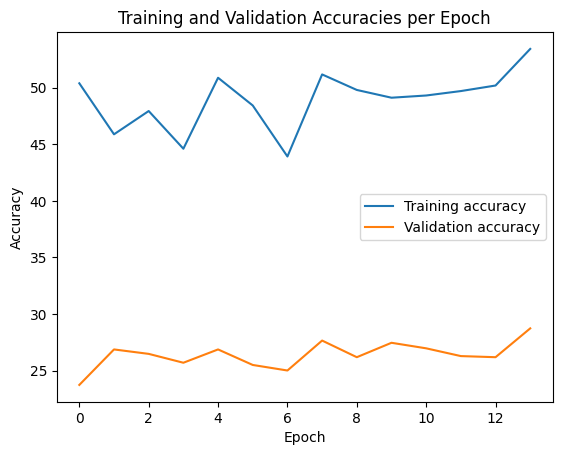

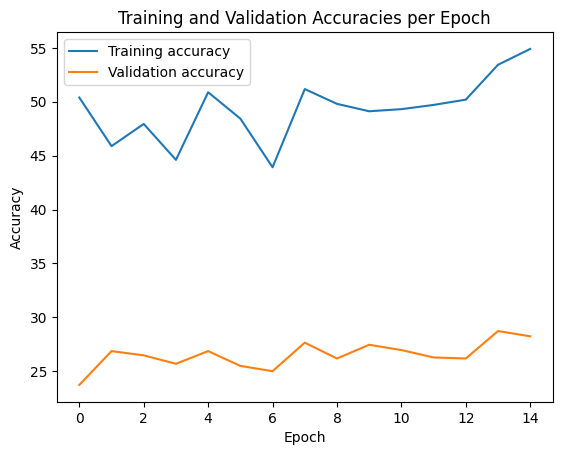

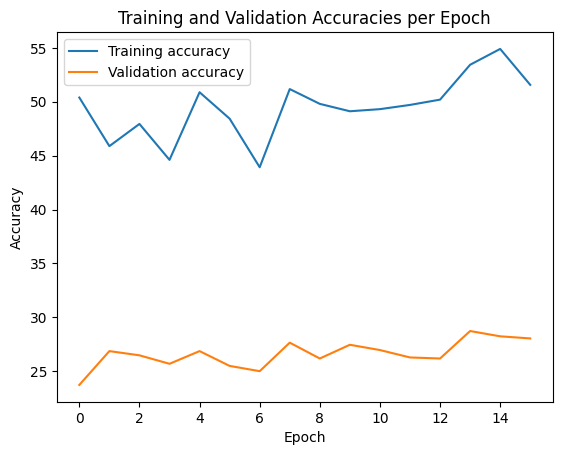

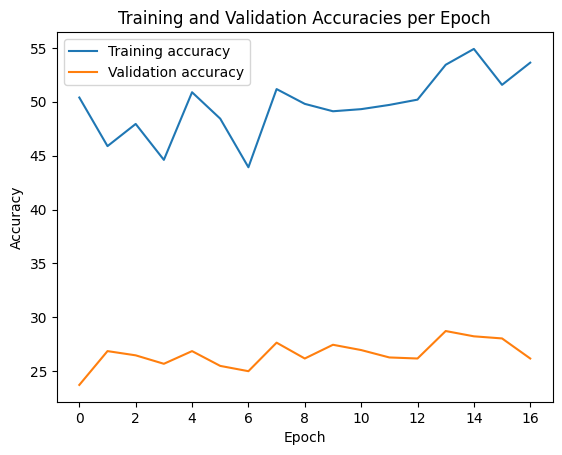

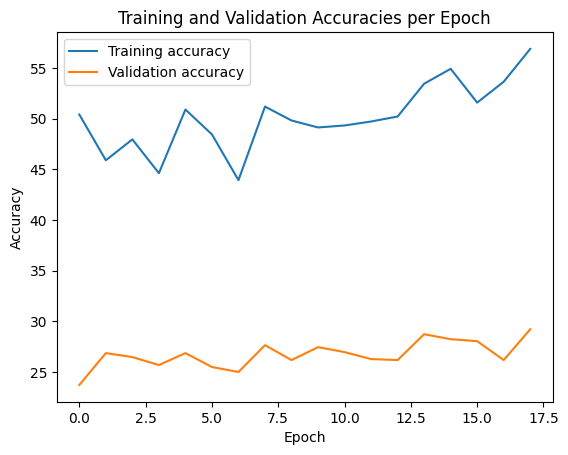

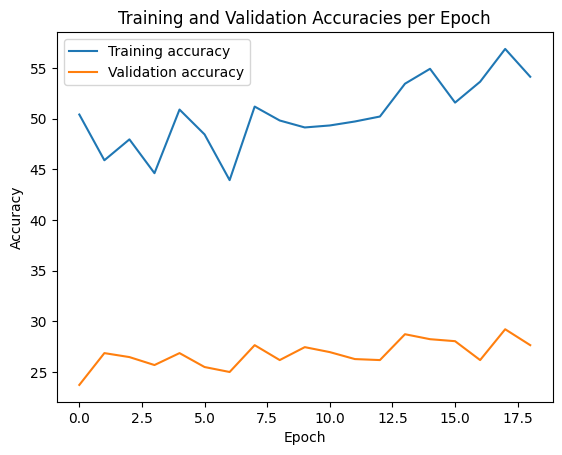

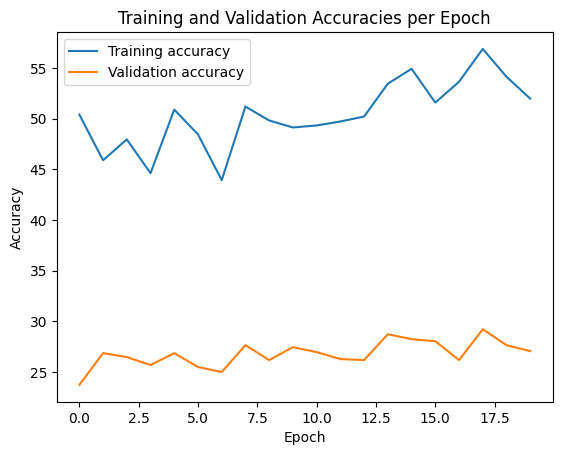

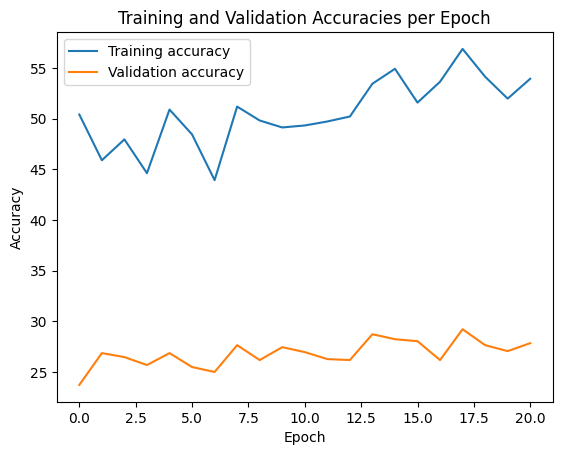

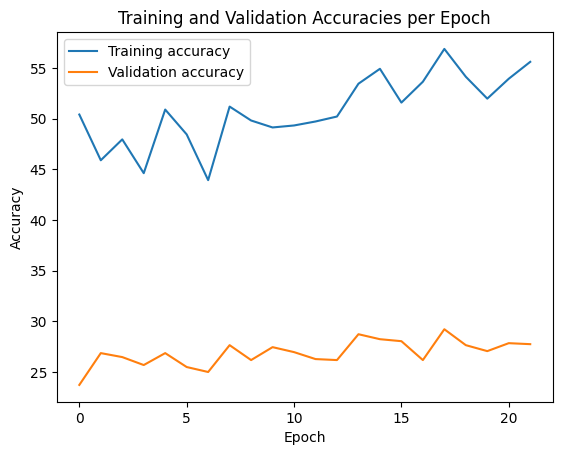

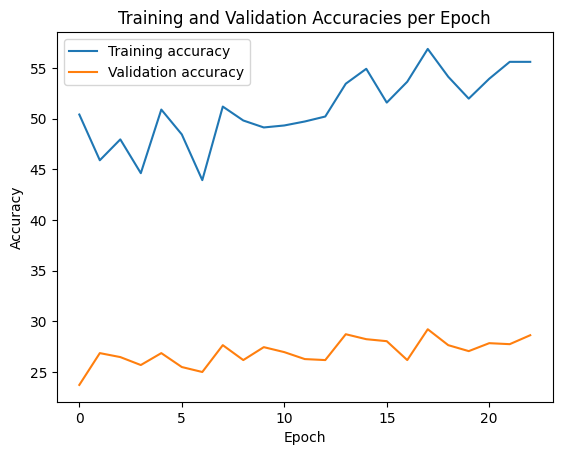

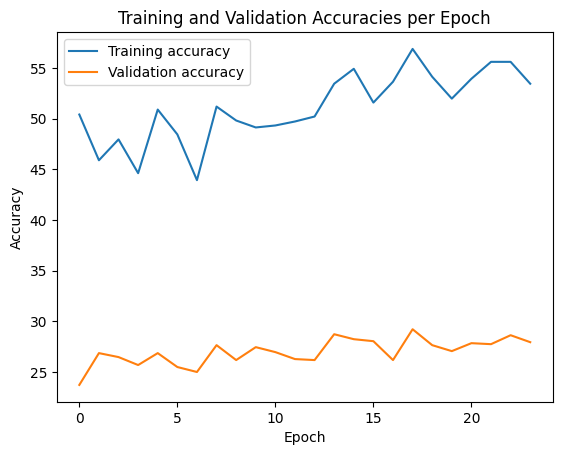

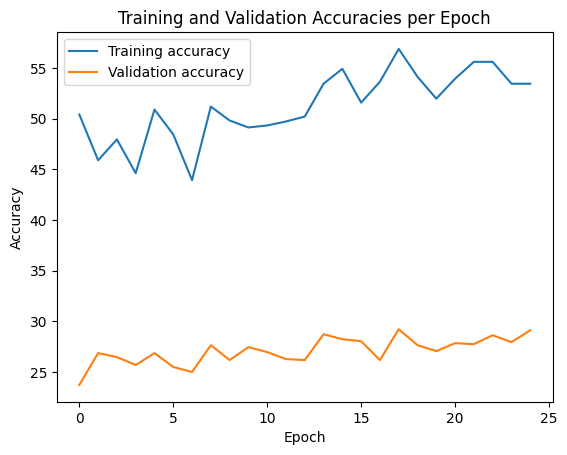

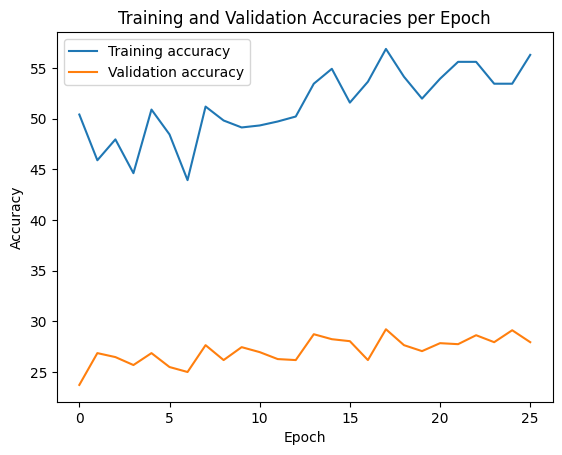

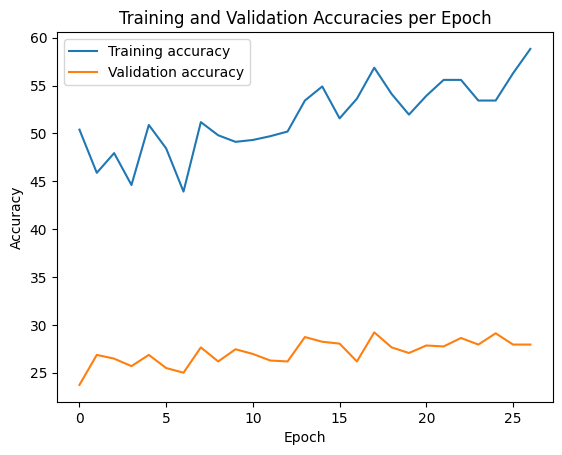

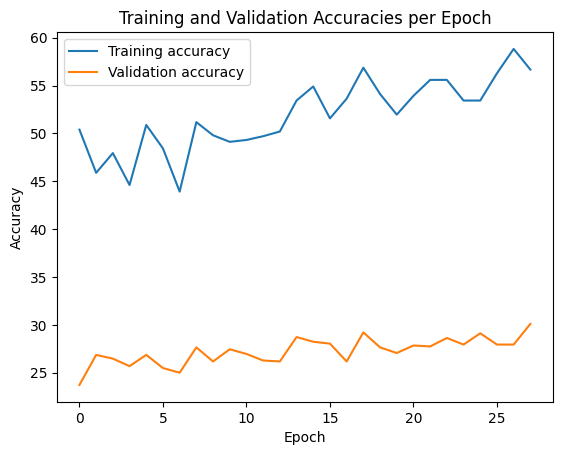

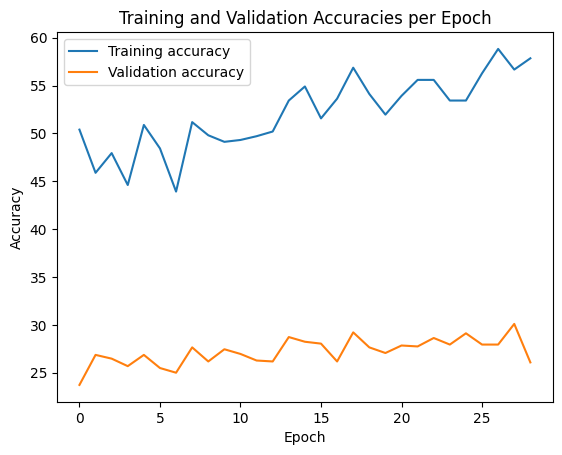

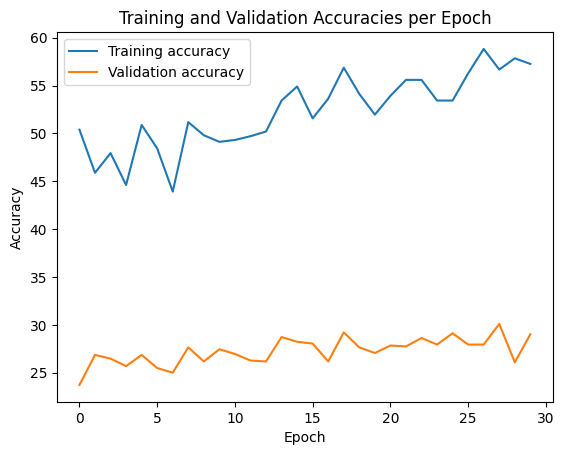

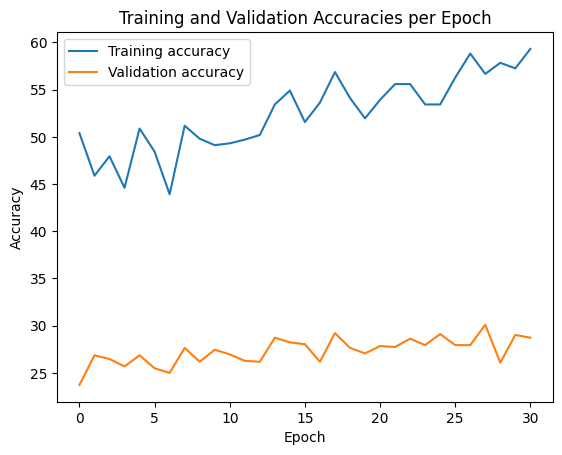

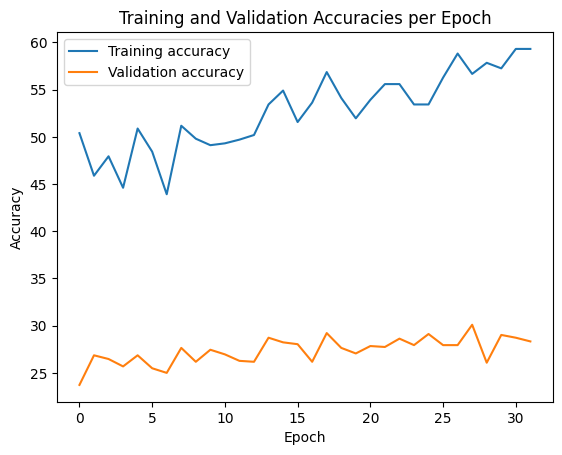

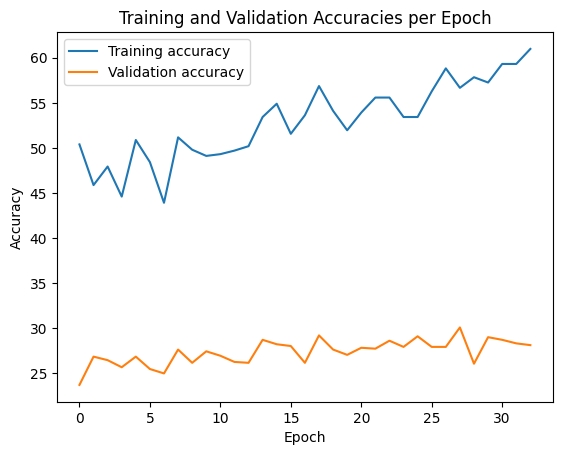

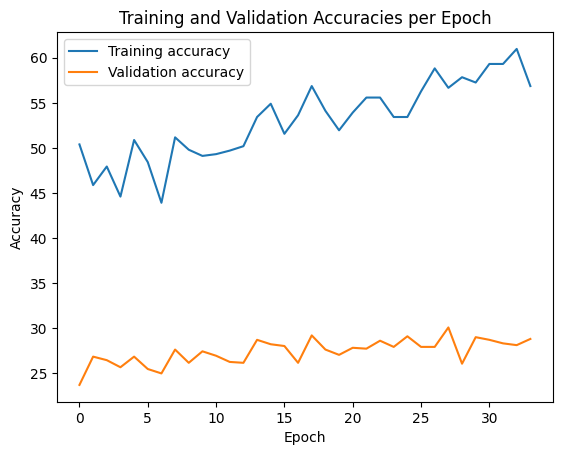

In [56]:
# Begin the training
trainOurModel("firstF102Model-500-DONE.pth")


In [69]:
testClasses(device)

Test Loss: 3.2613, Test Accuracy: 26.65%


In [ ]:
# Garbage Collection
gc.collect()